https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/02-regression/homework.md

The goal of this homework is to create a regression model for predicting housing prices (column '**median_house_value**').

In [380]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [381]:
def load_housing_data():
    return pd.read_csv('housing.csv')

In [382]:
df_raw = load_housing_data()
df_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


##### **Keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'**

In [383]:
def filter_ocean_proximity_records(df):
    return df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')]    

In [384]:
df = filter_ocean_proximity_records(df_raw)
df.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

##### **Data preparation**

In [385]:
def prepare_columns_names(df):
    data = df.copy()
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    return data

In [386]:
def prepare_string_column_values(df):
    data = df.copy()
    strings = list(data.dtypes[data.dtypes == 'object'].index)

    for col in strings:
        data[col] = data[col].str.lower().str.replace(' ', '_')
    
    return data

In [387]:
df = prepare_columns_names(df)
df = prepare_string_column_values(df)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1h_ocean
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1h_ocean
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1h_ocean
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1h_ocean
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1h_ocean


##### **Exploratory data analysis**

<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

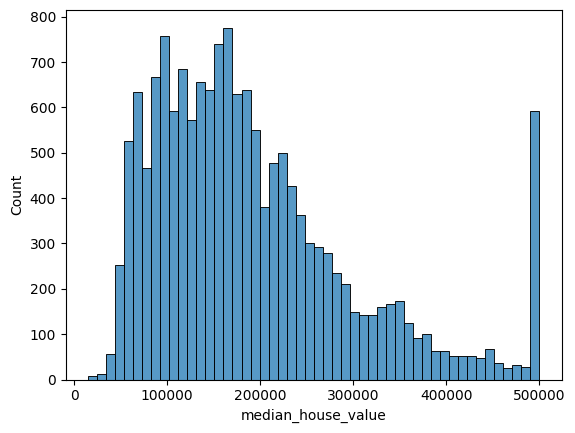

In [372]:
sns.histplot(df.median_house_value, bins=50)

<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

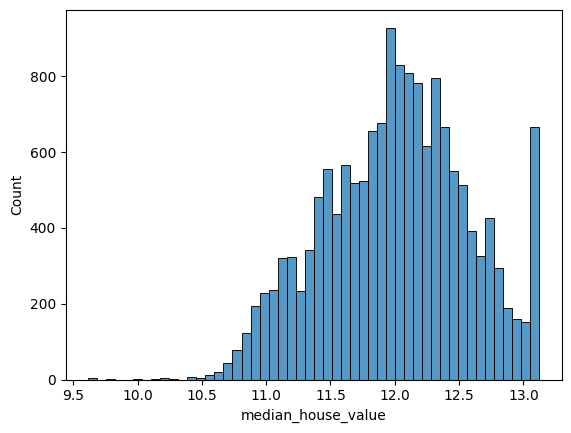

In [373]:
sns.histplot(np.log1p(df.median_house_value), bins=50)

##### **Setting up the validation framework**

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.

In [310]:
def calculate_subset_lengths(df):
    n = len(df)
    
    n_val = int(n * 0.2)       # 20%    
    n_test = int(n * 0.2)      # 20%
    n_train = n - nval - ntest # the rest

    return n_train, n_val, n_test

In [343]:
def split_into_train_val_test_subsets(df, seed=42):
    n_train, n_val, n_test = calculate_subset_lengths(df)

    # return evenly spaced values from 0 to n
    idx = np.arange(len(df))
    
    # shuffle ids
    np.random.seed(seed)
    np.random.shuffle(idx)

    # save subsets
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]

    # reset index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    return df_train, df_val, df_test

In [312]:
def extract_train_val_test_y_values(df_train, df_val, df_test, y_column_name):
    y_train = np.log1p(df_train[y_column_name].values)
    y_val = np.log1p(df_val[y_column_name].values)
    y_test = np.log1p(df_test[y_column_name].values)

    del df_train[y_column_name]
    del df_val[y_column_name]
    del df_test[y_column_name]

    return y_train, y_val, y_test

In [388]:
def setup_validation_framework(df, y_column_name, seed=42):
    # prepare data
    df_raw = load_housing_data()
    df = filter_ocean_proximity_records(df_raw)
    df = prepare_columns_names(df)
    df = prepare_string_column_values(df)
    
    # split into subsets
    df_train, df_val, df_test = split_into_train_val_test_subsets(df, seed)
    y_train, y_val, y_test = extract_train_val_test_y_values(df_train, df_val, df_test, y_column_name)

    return df_train, df_val, df_test, y_train, y_val, y_test
    

##### **Linear regression model**

In [243]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [288]:
def calc_prediction(X, w0, w):
    return w0 + X.dot(w)

##### **Regularization**

In [265]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

##### **Baseline model**

In [245]:
def prepare_X(df, base, fillna_value=0):    
    df_num = df[base]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

##### **RMSE**

In [246]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

***

### **Questions**

##### **Use only the following columns**:
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

In [321]:
base = [
    'latitude', 
    'longitude', 
    'housing_median_age', 
    'total_rooms', 
    'total_bedrooms', 
    'population', 
    'households', 
    'median_income'
]

##### **Question 1**
There's one feature with missing values. What is it?

* `total_rooms`
* `total_bedrooms` <=
* `population`
* `households`

In [390]:
df = filter_ocean_proximity_records(load_housing_data())
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

##### **Question 2**

What's the median (50% percentile) for variable `'population'`?

- 995
- 1095
- <mark>1195</mark>
- 1295

In [391]:
df = filter_ocean_proximity_records(load_housing_data())
df.population.median()

1195.0

##### **Question 3**

* We need to deal with missing values for the column from Question 1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- <mark>Both are equally good</mark>

In [392]:
df_train, df_val, df_test, y_train, y_val, y_test = setup_validation_framework(df, 'median_house_value', 42)

rmse=0.34


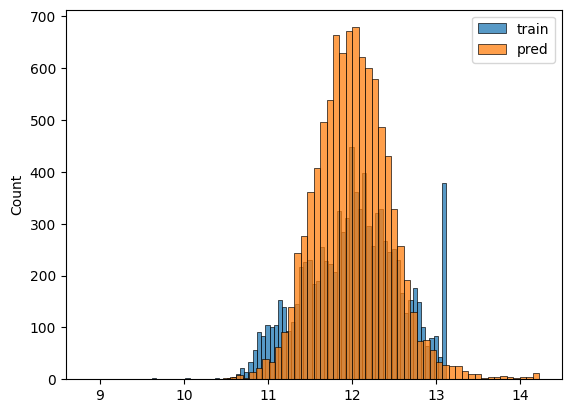

In [393]:
# Option 1
X_train = prepare_X(df_train, base, 0)

w0, w = train_linear_regression(X_train, y_train)
y_pred = calc_prediction(X_train, w0, w)

print(f"rmse={rmse(y_train, y_pred).round(2)}")

sns.histplot(y_train, bins=70, label='train')
sns.histplot(y_pred, bins=70, label='pred')
plt.legend()

rmse=0.34


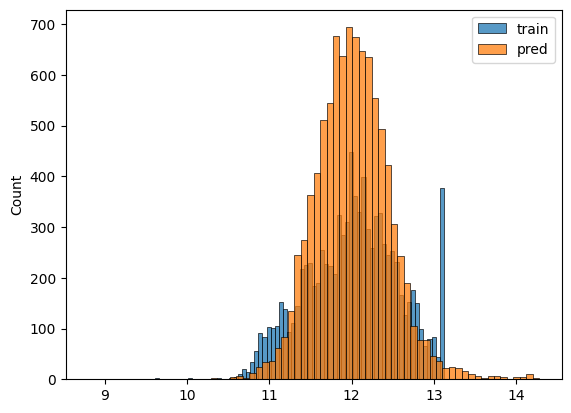

In [394]:
# Option 2
X_train = prepare_X(df_train, base, df_train.population.median())

w0, w = train_linear_regression(X_train, y_train)
y_pred = calc_prediction(X_train, w0, w)

print(f"rmse={rmse(y_train, y_pred).round(2)}")

sns.histplot(y_train, bins=70, label='train')
sns.histplot(y_pred, bins=70, label='pred')
plt.legend()

##### **Question 4**

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- <mark>0</mark>
- 0.000001
- 0.001
- 0.0001

In [395]:
df_train, df_val, df_test, y_train, y_val, y_test = setup_validation_framework(df, 'median_house_value')

In [396]:
best_r = 1000000
best_score = 1000000

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X(df_train, base)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)    
    
    X_val = prepare_X(df_val, base)
    y_pred = calc_prediction(X_val, w0, w)
        
    score = rmse(y_val, y_pred)

    if (score < best_score):
        best_score = score
        best_r = r
        
    print(r, w0, score)

print()
print(f"best_r: {best_r}, best_score: {best_score}")

0 -9.763249478100542 0.34084790341900123
1e-06 -9.763228831147018 0.3408479061790611
0.0001 -9.761185235961971 0.3408481800551529
0.001 -9.742646249920137 0.3408506921883878
0.01 -9.561056193036546 0.3408779300498141
0.1 -8.058889769552684 0.3412862041989286
1 -3.13315427844415 0.34489583276403035
5 -0.8410867974556349 0.34773980704861973
10 -0.4381172315400117 0.3483149833519123

best_r: 0, best_score: 0.34084790341900123


##### **Question 5**

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.5
- 0.05
- <mark>0.005</mark>
- 0.0005

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [398]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

best_seed = 1000000
best_score = 1000000

for seed in seed_values:
    df_train, df_val, df_test, y_train, y_val, y_test = setup_validation_framework(df, 'median_house_value', seed)

    # train model
    X_train = prepare_X(df_train, base)
    w0, w = train_linear_regression(X_train, y_train)

    # calc predictions based using trained model
    X_val = prepare_X(df_val, base)
    y_pred = calc_prediction(X_val, w0, w)
            
    score = rmse(y_val, y_pred)
    scores.append(score)
    
    if (score < best_score):
        best_score = score
        best_seed = seed
            
    print(seed, w0, score)
    
print()
print(f"best_seed: {best_seed}, best_score: {best_score}, score_standard_deviation: {np.std(scores).round(3)}")

0 -9.870068971097925 0.3377387160050441
1 -9.114011209993139 0.337799935366588
2 -9.911560201193756 0.3384287006763356
3 -10.233183681906137 0.3320049468307625
4 -9.174763450405491 0.33944518625550274
5 -10.006648303713407 0.34338197052534497
6 -10.039903099735962 0.3385330211773503
7 -10.353545444922416 0.3468747697301338
8 -9.899416167249983 0.35127368659575803
9 -9.964622125763638 0.33415582665074306

best_seed: 3, best_score: 0.3320049468307625, score_standard_deviation: 0.005


##### **Question 6**

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
- <mark>0.33</mark>
- 0.43

In [399]:
df_train, df_val, df_test, y_train, y_val, y_test = setup_validation_framework(df, 'median_house_value', seed=9)

In [400]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

In [401]:
y_full_train = np.concatenate([y_train, y_val])

In [402]:
X_full_train = prepare_X(df_full_train, base)
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)
    
X_test = prepare_X(df_test, base)
y_pred = calc_prediction(X_test, w0, w)
       
score = rmse(y_test, y_pred)
score

0.3349899336606186